In [1]:
from google.cloud import bigquery
from google.cloud import aiplatform
import bigframes.pandas as bpd
import pandas as pd
from vertexai.language_models._language_models import TextGenerationModel
from vertexai.generative_models import GenerativeModel
from bigframes.ml.cluster import KMeans
from bigframes.ml.model_selection import train_test_split

/usr/local/lib/python3.12/dist-packages/google/cloud/aiplatform/models.py:52: FutureWarning: Support for google-cloud-storage < 3.0.0 will be removed in a future version of google-cloud-aiplatform. Please upgrade to google-cloud-storage >= 3.0.0.
  from google.cloud.aiplatform.utils import gcs_utils


In [2]:
project_id = 'qwiklabs-gcp-02-fb515421c47e'
dataset_name = "ecommerce"
model_name = "customer_segmentation_model"
table_name = "customer_stats"
location = "us-central1"
client = bigquery.Client(project=project_id)
aiplatform.init(project=project_id, location=location)

In [3]:
%%bigquery
CREATE OR REPLACE TABLE ecommerce.customer_stats AS
SELECT
  user_id,
  DATE_DIFF(CURRENT_DATE(), CAST(MAX(order_created_date) AS DATE), day) AS days_since_last_order, ---RECENCY
  COUNT(order_id) AS count_orders, --FREQUENCY
  AVG(sale_price) AS average_spend --MONETARY
  FROM (
      SELECT
        user_id,
        order_id,
        sale_price,
        created_at AS order_created_date
        FROM `bigquery-public-data.thelook_ecommerce.order_items`
        WHERE
        created_at
            BETWEEN '2022-01-01' AND '2023-01-01'
  )
GROUP BY user_id;

Query is running:   0%|          |

""


Convert the table ecommerce.customer_stats to a bigframes dataframe and show the top 10 records

In [4]:
# prompt: Convert the table ecommerce.customer_stats to a bigframes dataframe and show the top 10 records

import pandas as pd
df_customer_stats = bpd.read_gbq(f'{project_id}.{dataset_name}.{table_name}')
df_customer_stats.head(10)

,user_id,days_since_last_order,count_orders,average_spend
0,4181,1229,1,35.950001
1,98371,1202,3,41.96
2,99595,1226,1,288.0
3,18060,1305,1,89.0
4,54180,1147,1,169.990005
5,33580,1191,1,45.990002
6,91472,1246,1,44.0
7,48863,1226,1,78.0
8,48563,1369,1,238.979996
9,96596,1161,4,65.997499


In [5]:
# prompt: bqdf = client.read_gbq(f"{project_id}.{dataset_name}.{table_name}")
# df.head(10)

df = client.query(f"SELECT * FROM `{project_id}.{dataset_name}.{table_name}`").to_dataframe()
df.head(10)

,user_id,days_since_last_order,count_orders,average_spend
0,88394,1107,1,48.000000
1,52841,1107,1,39.500000
2,99948,1107,1,174.990005
3,34596,1107,1,145.000000
4,58837,1107,1,39.990002
5,44695,1107,1,26.990000
6,18405,1107,1,64.000000
7,47035,1107,1,25.000000
8,71698,1107,1,44.000000
9,51,1107,1,46.759998


In [6]:
bqdf = bpd.read_gbq(f"{project_id}.{dataset_name}.{table_name}")
bqdf.head(10)

/usr/local/lib/python3.12/dist-packages/bigframes/core/log_adapter.py:182: TimeTravelCacheWarning: Reading cached table from 2026-01-11 07:07:50.945843+00:00 to avoid
incompatibilies with previous reads of this table. To read the latest
version, set `use_cache=False` or close the current session with
Session.close() or bigframes.pandas.close_session().
  return method(*args, **kwargs)


,user_id,days_since_last_order,count_orders,average_spend
0,4181,1229,1,35.950001
1,98371,1202,3,41.96
2,99595,1226,1,288.0
3,18060,1305,1,89.0
4,54180,1147,1,169.990005
5,33580,1191,1,45.990002
6,91472,1246,1,44.0
7,48863,1226,1,78.0
8,48563,1369,1,238.979996
9,96596,1161,4,65.997499


In [7]:
# prompt: #prompt: 1. Split df (using random state and test size 0.2) into test and training data for a K-means clustering algorithm store these as df_test and df_train. 2. Create a K-means cluster model using bigframes.ml.cluster KMeans with 5 clusters. 3. Save the model using the to_gbq method where the model name is project_id.dataset_name.model_name.
# df_train, df_test = train_test_split(bq_df, test_siz

df_train, df_test = train_test_split(bqdf, test_size=0.2, random_state=42)

kmeans = KMeans(n_clusters=5)
kmeans.fit(df_train)

kmeans.to_gbq(f"{project_id}.{dataset_name}.{model_name}")

KMeans(distance_type='EUCLIDEAN', init='KMEANS_PLUS_PLUS', n_clusters=5)

In [8]:
# prompt: # prompt: 1. Call the K-means prediction model on the df dataframe, and store the results as predictions_df and show the first 10 records.
# predictions_df = kmeans.predict(df_test)
# predictions_df.head(10)

predictions_df = kmeans.predict(df_test)
predictions_df.head(10)

,CENTROID_ID,NEAREST_CENTROIDS_DISTANCE,user_id,days_since_last_order,count_orders,average_spend
3,3,"[{'CENTROID_ID': 3, 'DISTANCE': 0.854454442441...",18060,1305,1,89.0
10,4,"[{'CENTROID_ID': 4, 'DISTANCE': 2.058702111098...",92476,1126,3,67.970001
23,5,"[{'CENTROID_ID': 5, 'DISTANCE': 0.691068256831...",60947,1142,1,18.950001
24,5,"[{'CENTROID_ID': 5, 'DISTANCE': 1.141982803881...",61162,1262,2,60.984999
27,1,"[{'CENTROID_ID': 1, 'DISTANCE': 1.074638661364...",95561,1326,1,54.990002
30,5,"[{'CENTROID_ID': 5, 'DISTANCE': 0.981490520981...",78362,1228,2,30.21
31,4,"[{'CENTROID_ID': 4, 'DISTANCE': 3.778632607888...",69907,1126,7,56.101429
50,2,"[{'CENTROID_ID': 2, 'DISTANCE': 1.481700417382...",22097,1193,1,160.0
56,4,"[{'CENTROID_ID': 4, 'DISTANCE': 1.604443299174...",67074,1375,3,31.626666
57,1,"[{'CENTROID_ID': 1, 'DISTANCE': 0.987950798738...",82149,1460,1,25.200001


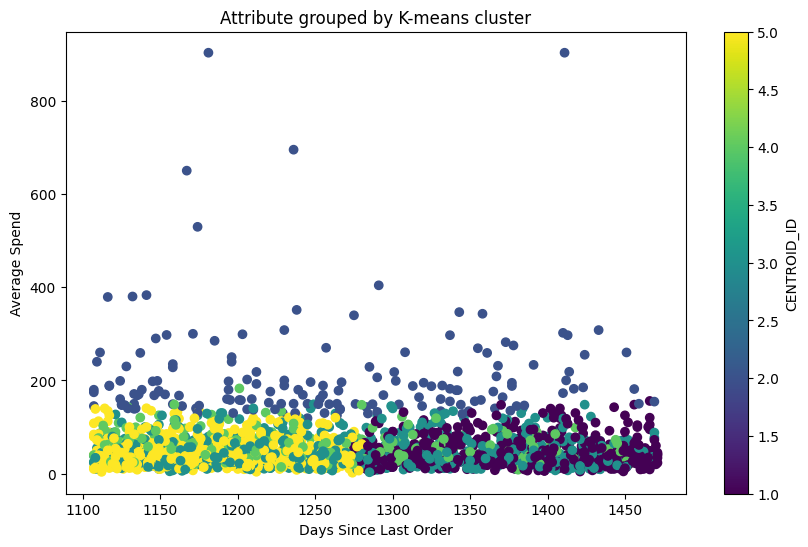

In [9]:
# prompt: #prompt: 1. Using predictions_df, and matplotlib, generate a scatterplot. 2. On the x-axis of the scatterplot, display days_since_last_order and on the y-axis, display average_spend from predictions_df. 3. Color by cluster. 4. The chart should be titled "Attribute grouped by K-means cluster."
# import matplotlib.pyplot as plt
# # Create the scatter plot
# plt.figure(figsize=(10, 6))  # Adjust figure s

import matplotlib.pyplot as plt
# Create the scatter plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(predictions_df['days_since_last_order'], predictions_df['average_spend'], c=predictions_df['CENTROID_ID'], cmap='viridis')
plt.xlabel('Days Since Last Order')
plt.ylabel('Average Spend')
plt.title('Attribute grouped by K-means cluster')
plt.colorbar(label='CENTROID_ID')
plt.show()

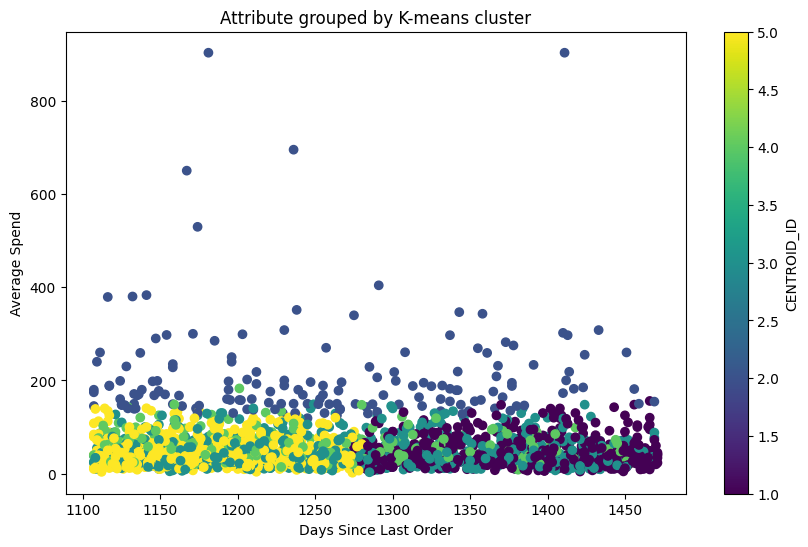

In [10]:
# prompt: 1. Using predictions_df, and matplotlib, generate a scatterplot. 2. On the x-axis of the scatterplot, display days_since_last_order and on the y-axis, display average_spend from predictions_df. 3. Color by cluster. 4. The chart should be titled "Attribute grouped by K-means cluster."

import matplotlib.pyplot as plt
# Create the scatter plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(predictions_df['days_since_last_order'], predictions_df['average_spend'], c=predictions_df['CENTROID_ID'], cmap='viridis')
plt.xlabel('Days Since Last Order')
plt.ylabel('Average Spend')
plt.title('Attribute grouped by K-means cluster')
plt.colorbar(label='CENTROID_ID')
plt.show()

In [11]:
query = """
SELECT
 CONCAT('cluster ', CAST(centroid_id as STRING)) as centroid,
 average_spend,
 count_orders,
 days_since_last_order
FROM (
 SELECT centroid_id, feature, ROUND(numerical_value, 2) as value
 FROM ML.CENTROIDS(MODEL `{0}.{1}`)
)
PIVOT (
 SUM(value)
 FOR feature IN ('average_spend',  'count_orders', 'days_since_last_order')
)
ORDER BY centroid_id
""".format(dataset_name, model_name)

df_centroid = client.query(query).to_dataframe()
df_centroid.head()

,centroid,average_spend,count_orders,days_since_last_order
0,cluster 1,45.60,1.27,1379.66
1,cluster 2,201.26,1.24,1262.49
2,cluster 3,46.59,1.27,1273.56
3,cluster 4,58.48,3.67,1249.71
4,cluster 5,44.23,1.30,1179.72


In [12]:
df_query = client.query(query).to_dataframe()
df_query.to_string(header=False, index=False)

cluster_info = []
for i, row in df_query.iterrows():
 cluster_info.append("{0}, average spend ${2}, count of orders per person {1}, days since last order {3}"
  .format(row["centroid"], row["count_orders"], row["average_spend"], row["days_since_last_order"]) )

cluster_info = (str.join("\n", cluster_info))
print(cluster_info)

cluster 1, average spend $45.6, count of orders per person 1.27, days since last order 1379.66
cluster 2, average spend $201.26, count of orders per person 1.24, days since last order 1262.49
cluster 3, average spend $46.59, count of orders per person 1.27, days since last order 1273.56
cluster 4, average spend $58.48, count of orders per person 3.67, days since last order 1249.71
cluster 5, average spend $44.23, count of orders per person 1.3, days since last order 1179.72


In [13]:
prompt = f"""
You're a creative brand strategist, given the following clusters, come up with \
creative brand persona, a catchy title, and next marketing action, \
explained step by step.

Clusters:
{cluster_info}

For each Cluster:
* Title:
* Persona:
* Next marketing step:
"""

In [14]:
model = GenerativeModel("gemini-2.5-pro")

prompt = f"""
You're a creative brand strategist, given the following clusters, come up with \
creative brand persona, a catchy title, and next marketing action, \
explained step by step. Identify the cluster number, the title of the person, a persona for them and the next marketing step.

Clusters:
{cluster_info}

For each Cluster:
* Title:
* Persona:
* Next marketing step:
"""

responses = model.generate_content(
   prompt,
   generation_config={
      "temperature": 0.1,
      "max_output_tokens": 4000,
      "top_p": 1.0,
      "top_k": 40,
   }
)

print(responses.text)

/usr/local/lib/python3.12/dist-packages/vertexai/generative_models/_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


Of course. As a creative brand strategist, my goal is to transform raw data into human stories and actionable growth plans. The most glaring insight across all these clusters is the `days since last order`—all are over 1,100 days, meaning these are deeply lapsed customers (3+ years). Our strategy must be centered on reactivation, with the understanding that many of these customers may be lost for good.

Here is the strategic breakdown for each cluster.

***

### **Cluster 1**

*   **Data:** Average spend $45.60, count of orders 1.27, days since last order 1379.66 (~3.8 years)

*   **Title:** **The Drive-By Shopper**

*   **Persona:** This person is the digital equivalent of someone who pulls off the highway for a quick snack and never thinks about that gas station again. Their purchase was likely driven by a specific, fleeting need—a last-minute gift, a niche item they found via a Google search, or a single purchase from a social media ad. They have zero brand loyalty to us. The produc

In [15]:
# Future Cloud Skill
### Thanks for watching.
### Please subscribe to the Future Cloud Skill channel
print("youtube.com/@futurecloudskill")


youtube.com/@futurecloudskill
